In [ ]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import seaborn as sns
import argparse
import datetime
import graphviz
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## other

In [ ]:
def argspace(*funcs, **kwds):
  def deco(f):
    def inner(**ikwds):
      for g in funcs:
        kwds.update(g())
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [ ]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [ ]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f, order):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(order, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      funcs = sorted(self.func[key].values(), key=lambda x: x[0])
      return [g(*args, **kwds) for _, g in funcs]
    return f

  def event(*key, order=0):
    def d(f):
      for k in key:
        Experiment()._store(k, f, order)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [ ]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [ ]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [ ]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

In [ ]:
def count_param(model : nn.Module):
  param = model.named_parameters()
  itr = [np.prod(v.size()) for name, v in param if "auxiliary" not in name]
  return np.sum(itr)

In [ ]:
from typing import Union
from collections import OrderedDict
@torch.no_grad()
def square_error(m : Union[nn.Module, OrderedDict], n : Union[nn.Module, OrderedDict]):
  m = m.parameters() if isinstance(m, nn.Module) else m.values()
  n = n.parameters() if isinstance(n, nn.Module) else n.values()
  s = [torch.sum((x - y) * (x - y)) for x, y in zip(m, n)]
  return sum(s)

## save

In [ ]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [ ]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [ ]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [ ]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [ ]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def apply(self, name, func):
    if not name in self.dict:
      self.dict[name] = []
    return func(self.dict[name])

  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

In [ ]:
def render_graph(graph, path):
  format = dict(
      format='png', 
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot' # circo, dot, fdp, neato, osage, sfdp, twopi
  )

  dg = graphviz.Digraph(**format)

  dg.attr('node', fillcolor='dodgerblue4', fontcolor='white', fontsize='15') # coral, 
  for node in graph.nodes():
    attr = graph.nodes[node]
    label = attr['name'] if 'name' in attr else str(node)
    label += '\n(%s, %d, %d)' % (attr['channel'], 32 / attr['stride'], 32 / attr['stride'])
    dg.node(str(node), label=label)

  for (i, j) in graph.edges():
    attr = graph.edges[i, j]
    label = attr['module']
    label = ""
    style = 'bold' if attr['module'] == 'forward' else 'dashed'
    dg.edge(str(i), str(j), label=label, style=style)

  dg.render(path)
  return dg

In [ ]:
def save_heatmap(data : torch.tensor, path, format='1.2f'):
  plt.figure()
  data = data.detach().cpu().clone().numpy()
  sns.heatmap(data, annot=True, fmt=format)
  plt.savefig(path)
  plt.close('all')

# dataset

In [ ]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [ ]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs) if args.valid_size else None
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

## sampler

In [ ]:
class ArchitectureSampler():
  def __call__(self, graph : nx.DiGraph, alpha : torch.Tensor) -> nx.DiGraph:
    return self.graph(graph, alpha)

In [ ]:
class MaxSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      edge_num = round(sum(alphas))
      disable = sorted(zip(edges, alphas), key=lambda x: x[-1])[:-edge_num]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [ ]:
class EdgewiseSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      disable = [(e, a) for e, a in zip(edges, alphas) if round(a) < 1]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [ ]:
class ForwardSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if not i + 1 == j]
      G.remove_edges_from(edges)

    return G

In [ ]:
class StrideCutSampler(ArchitectureSampler):
  def __init__(self, stride_max=8):
    assert stride_max >= 1
    self.stride = stride_max

  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if G.edges[i, j]['stride'] > self.stride]
      G.remove_edges_from(edges)

    return G

In [ ]:
# args = {'gene':'VGG19', 'stride_max':2}
# model = load_model(dir="exp_vgg19_beta_zero-2020-10-07_12-10-48", **args)
# g = model.graph
# sampler = EdgewiseSampler()
# h = model.sampled_graph(sampler)
# render_graph(h, 'graph')
# # nx.graph_edit_distance(g, h)

## component

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [ ]:
class FactorizedReduce(nn.Module):
  def __init__(self, channel_in, channel_out, stride, affine=True):
    super(FactorizedReduce, self).__init__()
    assert channel_out % stride == 0
    
    self.convs = nn.ModuleList([
      nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False)
      for _ in range(stride)
    ])
    self.bn = nn.BatchNorm2d(channel_out, affine=affine)

  def forward(self, x):
    # strideの偶奇による情報ロスを防ぐ
    out = torch.cat([conv(x[:,:,i:,i:]) for i, conv in enumerate(self.convs)], dim=1)
    out = self.bn(out)
    return out

In [ ]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if stride > 1:
      return FactorizedReduce(channel_in, channel_out, stride)
    elif channel_in != channel_out:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [ ]:
class Block(nn.Module):
  def __init__(self, graph, index):
    super(Block, self).__init__()
    node = graph.nodes[index]
    edges = [(i, index, graph.edges[i, index]) for i in graph.predecessors(index)]

    self.index = index
    self.indices = [i for i, _, _ in edges]
    self.edges = nn.ModuleList([self._build_module(s) for i, j, s in edges])

    process = [nn.ReLU(inplace=True)]
    if node['pool']: process += [nn.MaxPool2d(kernel_size=2, stride=2)]
    self.post_process = nn.Sequential(*process)

  def _build_module(self, setting):
    module = setting['module']
    in_channel, out_channel = setting['channel']
    stride = setting['stride']
    if module == 'forward':
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel)
          )
    elif module == 'shortcut':
      return Shortcut(in_channel, out_channel, stride)
    else:
      raise ValueError("module name")

  def forward(self, inputs, alpha):
    output = sum(alpha[i] * F(inputs[i]) for i, F in zip(self.indices, self.edges))
    return self.post_process(output)

## network

In [ ]:
# 前提条件 : make graph, modules(Block, pool, ...)
# 拘束条件 : alpha sofmax
class Network(nn.Module):
  def __init__(self, gene, graph=None, preprocess : ArchitectureSampler=None):
    super(Network, self).__init__()
    self.gene = gene
    self.evaluate = bool(graph)
    self.graph = graph if graph else self._make_graph(gene)
    self.graph = preprocess(self.graph, None) if preprocess else self.graph

    self.blocks = nn.ModuleList(self._make_blocks(self.graph))
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _make_graph(self, gene, color_channel=3):
    
    def _decode_gene(gene):
      ch, st = [], []
      for g in gene:
        if g == 'M':
          st[-1] *= 2
        else :
          ch += [g]
          st += [1]
      return ch, st

    def __pi(array):
      r = []
      s = 1
      for q in array:
        s *= q
        r += [s]
      return r

    channel, stride = _decode_gene(gene)
    channel = [color_channel] + channel
    stride = [1] + stride
    s_stride = __pi(stride)

    n = len(channel)
    nodes = [(i, {'channel':channel[i], 'stride':s_stride[i], 'pool':stride[i]>1}) for i in range(n)]
    nodes[0][-1].update({'name':'input'})
    edges = [(i, j, {}) for i in range(n) for j in range(n) if i < j and not (i == 0 and j > 1)]
    for (i, j, d) in edges:
      d.update({
        'module' : 'forward' if i + 1 == j else 'shortcut', 
        'channel' : (nodes[i][-1]['channel'], nodes[j][-1]['channel']),
        'stride' : int(nodes[j-1][-1]['stride'] / nodes[i][-1]['stride'])
      })

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

  def _make_blocks(self, graph):
    return [Block(graph, i) for i in graph.nodes() if i > 0]

  def init_alpha(self, device):
    def _init_alpha(node_num, device, delta=1e-3):
      noise = delta * torch.randn(node_num, node_num, device=device)
      alpha = noise.clone().detach().requires_grad_(True)
      return [alpha]

    def _mask(node_num, device, name):
      mask = torch.zeros(node_num, node_num, device=device)

      for i, j in self.graph.edges():
        op = self.graph.edges[i, j]['module']
        if not op == name: continue

        mask[i, j] = 1

      return mask.t() > 0

    n = self.graph.number_of_nodes()
    self.alphas = _init_alpha(n, device)
    self.mask_s = _mask(n, device, 'shortcut')
    self.mask_f = _mask(n, device, 'forward')

    # self.alphas += [torch.ones(n, device=device, requires_grad=True)]
    self.alphas += [torch.zeros(n, device=device, requires_grad=True)]

    return self

  def normalized_alpha(self):
    alpha = torch.zeros_like(self.alphas[0])
    if self.evaluate:
      for i, j in self.graph.edges():
        alpha[j, i] = 1.0
    else:
      alpha[self.mask_f] = 1.0
      for a, raw, mask, b in zip(alpha, self.alphas[0], self.mask_s, self.normalized_beta()):
        a[mask] = b * F.softmax(raw[mask], dim=0)
    return alpha

  def normalized_beta(self):
    # f = lambda x : math.exp(x - 1) if x < 1 else math.log(x) + 1
    # return self.beta().apply_(f)
    x = self.beta()
    m = x>1
    beta = torch.zeros_like(x)
    beta[m] = torch.log(x[m]) + 1
    beta[~m] = torch.exp(x[~m] - 1)
    return beta

  def beta(self):
    return self.alphas[1]

  def sampled_graph(self, sampler : ArchitectureSampler):
    return sampler(self.graph, self.matrix_alpha())

  @torch.no_grad()
  def matrix_alpha(self, normalize=True):
    return (self.normalized_alpha() if normalize else self.alphas[0]).t()


  def forward(self, x):
    state = [x]
    alpha = self.normalized_alpha()

    for block in self.blocks:
      x = block(state, alpha[block.index])
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

## architecture

In [ ]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device
    self.train = True

  def step(self):
    if not self.valid_loader: return
    if not self.train: return
    
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

# learning

## events

In [ ]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [ ]:
@Experiment.event('setup')
def set_device(args):
  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

In [ ]:
@Experiment.event('epoch_start')
def logging_alpha(args):
  model = args.model
  if not model.evaluate:
    logging.info('raw %s', model.matrix_alpha(normalize=False))
    logging.info('alpha %s', model.matrix_alpha())
    logging.info('beta %s', model.beta())

In [ ]:
@Experiment.event('epoch_start')
def logging_lr(args):
  def get_lr(optimizer):
    for param_group in optimizer.param_groups:
      return param_group['lr']

  if args.scheduler:
    # logging.info('lr %s', get_lr(args.optimizer))
    args.store.add("lr", get_lr(args.optimizer))

In [ ]:
@Experiment.event('train_end')
def train_end(args, data):
  train_acc, train_obj = data
  # logging.info('train_acc %f', train_acc)
  args.store.add("train_loss", train_obj)
  args.store.add("train_acc", train_acc)

In [ ]:
@Experiment.event('test_end')
def test_end(args, data):
  valid_acc, valid_obj = data
  # logging.info('valid_acc %f', valid_acc)
  args.store.add("test_loss", valid_obj)
  args.store.add("test_acc", valid_acc)

In [ ]:
@Experiment.event('end', order=1)
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [ ]:
@Experiment.event('end')
def aggregate_data(args):
  store = args.store
  m = store.apply('test_acc', max)
  store.add('test_acc' + '_best', m)
  logging.info('best acc %s' % m)

In [ ]:
@Experiment.event('checkpoint', 'end')
def save_model(args):
  # state = {
  #   'model': args.model.state_dict(),
  #   'graph': args.model.graph,
  #   'alpha': args.model.alphas,
  #   'store': args.store,
  #   'epoch': args.epoch,
  # }
  # torch.save(state, os.path.join(args.save, 'checkpoint.pth'))
  pass

In [ ]:
@Experiment.event('epoch_end')
def save_graph(args):
  path = os.path.join(args.save, 'graph')
  if not os.path.exists(path):
    os.mkdir(path)
  sampler = MaxSampler()
  graph = args.model.sampled_graph(sampler)
  torch.save(graph, os.path.join(path, 'graph_%d.pth' % args.epoch))
  render_graph(graph, os.path.join(path, 'graph_%d' % args.epoch))

In [ ]:
@Experiment.event('epoch_end')
def save_alpha(args):
  path = os.path.join(args.save, 'alpha')
  if not os.path.exists(path):
    os.mkdir(path)
  save_heatmap(args.model.matrix_alpha(), os.path.join(path, 'alpha_%d.png' % args.epoch))

In [ ]:
@Experiment.event('epoch_end')
def save_weight(args):
  if not args.save_weight: return

  path = os.path.join(args.save, 'model')
  if not os.path.exists(path):
    os.mkdir(path)
  torch.save(args.model.state_dict(), os.path.join(path, 'model_%d.pth' % args.epoch))

## learning

In [ ]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    # if step % args.report_freq == 0:
      # logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [ ]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    # if step % args.report_freq == 0:
      # logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

## setting

In [ ]:
def default_setting():
  default_args = argparse.Namespace(
      gene='VGG19', momentum=0.9, report=100, checkpoint=10,
      stride_max=2, batch_size=64, dir="", graph=None, lr_alpha=0.0,
      save_weight=False, seed=41, scheduler=None)
  return vars(default_args)

## experiment

In [ ]:
@argspace(gene='VGG11', stride_max=0, graph=None, dir=None)
def load_model(args):
  
  # init
  set_device(args)
  device = args.device

  # model setup
  gene = cfg[args.gene]
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  model = Network(gene, graph=args.graph, preprocess=sampler).to(device).init_alpha(device)

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']

  return model

In [ ]:
@argspace(default_setting)
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device


  # model setup
  gene = cfg[args.gene]
  logging.info('gene %s', gene)
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  graph = args.graph if args.graph else None
  model = Network(gene, graph=graph, preprocess=sampler).to(device).init_alpha(device)
  logging.info('model param %s', count_param(model))

  # load cuda
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  args.model = model

  # env
  loader = load_dataloader(args)
  args.optimizer = optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device)
  if args.scheduler:
    args.scheduler = args.scheduler(optimizer, **args.scheduler_args)



  for epoch in tqdm(range(args.start_epoch + 1, args.epochs + 1)):
    # logging.info('epoch %d', epoch)
    args.epoch = epoch
    
    exp('epoch_start')(args)
    
    if not model.evaluate:
      architect.train = epoch >= args.weight_epoch

    # training
    train_result = train(dataset=loader.train, model=model, 
                         criterion=criterion, optimizer=optimizer, 
                         architect=architect, 
                         device=device, report_freq=args.report)
    exp('train_end')(args, train_result)

    # validation
    valid_result = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    exp('test_end')(args, valid_result)

    if args.scheduler:
      _, loss = valid_result
      args.scheduler.step()

    exp('epoch_end')(args)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)

  exp('end')(args)

  return args

In [ ]:
@argspace(default_setting)
def evaluate(args):
  model = load_model(dir=args.dir, gene=args.gene, stride_max=args.stride_max)
  
  sampler : ArchitectureSampler = args.sampler
  graph = model.sampled_graph(sampler)

  args.origin_dir = args.dir
  args.dir = ""
  args.graph = graph
  return main(**vars(args))

In [ ]:
! pip install optuna

import optuna

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@argspace()
def run_optuna(args):
  bar = tqdm(total = args.trials)

  def objective(trial):
    lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
    # name = trial.suggest_categorical('scheduler', ['exp', 'step'])
    name = 'step'
    step = trial.suggest_int('step', 20, 140, 20)
    gamma = trial.suggest_uniform('gamma', 0.0, 1.0)

    # if name == 'exp':
    #   scheduler = optim.lr_scheduler.ExponentialLR
    #   option = {'gamma':0.1 ** (1 / step)}

    if name == 'step':
      scheduler = optim.lr_scheduler.StepLR
      option = {'gamma':gamma, 'step_size':step}

    output = evaluate(save='%s_no-%03d' % (args.study, trial.number), lr=lr, epochs=200,
        scheduler=scheduler, scheduler_args=option,
        train_size=2000, valid_size=0, test_size=200, sampler=ForwardSampler(),
        checkpoint=100, report=1000, dir=args.root_dir)
    
    bar.update(1)

    score = output.store.apply('test_loss', min)
    return score

  study_name = args.study
  storage = os.path.join('sqlite:///./', args.save, args.storage)
  study = optuna.create_study(study_name=study_name, storage=storage, load_if_exists=True)
  study.optimize(objective, n_trials=args.trials)

  print('best', study.best_trial)

  return study

In [ ]:
@argspace()
def log_study(args):
  study_name = args.study
  storage = os.path.join('sqlite:///./', args.save, args.storage)
  study = optuna.create_study(study_name=study_name, storage=storage, load_if_exists=True)

  print('best', study.best_trial)

  return study

# main

In [ ]:
if __name__ == '__main__':
  log_study(save="drive/My Drive/database", storage='vgg_eval.db',
             study='step_scheduler2', root_dir=None, trials=10)

[I 2020-10-19 07:54:37,943] Using an existing study with name 'step_scheduler2' instead of creating a new one.


best FrozenTrial(number=47, value=0.9482056069374084, datetime_start=datetime.datetime(2020, 10, 19, 6, 19, 23, 681145), datetime_complete=datetime.datetime(2020, 10, 19, 6, 30, 59, 238575), params={'gamma': 0.23439853967807633, 'learning_rate': 0.009013149355146808, 'step': 100}, distributions={'gamma': UniformDistribution(high=1.0, low=0.0), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-06), 'step': IntUniformDistribution(high=140, low=20, step=20)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=165, state=TrialState.COMPLETE)


In [ ]:
if __name__ == '__main__':
  run_optuna(save="drive/My Drive/database", storage='vgg_eval.db',
             study='step_scheduler2', root_dir=None, trials=10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
if __name__ == '__main__':
  log_study(save="drive/My Drive/database", storage='vgg_eval.db',
             study='step_scheduler', root_dir=None, trials=10)

[I 2020-10-16 01:32:04,626] Using an existing study with name 'step_scheduler' instead of creating a new one.


best FrozenTrial(number=13, value=0.8869010543823242, datetime_start=datetime.datetime(2020, 10, 14, 14, 15, 13, 53958), datetime_complete=datetime.datetime(2020, 10, 14, 14, 23, 1, 998689), params={'learning_rate': 0.00950500570776145, 'step': 90}, distributions={'learning_rate': LogUniformDistribution(high=0.1, low=0.0001), 'step': IntUniformDistribution(high=100, low=30, step=10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=84, state=TrialState.COMPLETE)


In [ ]:
if __name__ == '__main__':
  run_optuna(save="drive/My Drive/database", storage='vgg_eval.db',
             study='step_scheduler', root_dir=None, trials=10)

In [ ]:
if __name__ == '__main__':
  run_optuna(save="drive/My Drive/database", storage='vgg_eval.db',
             study='eval_scheduler', root_dir=None, trials=10)

In [ ]:
if __name__ == '__main__':
  for i in [5, 6, 7]:
    main(save="exp_vgg19_search%s" % i, lr=0.01, lr_alpha=0.003, epochs=50, weight_epoch=10,
        train_size=25000, valid_size=25000, test_size=5000, save_weight=False, seed=(i+40))

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_test", lr=0.1, epochs=300,
       scheduler=optim.lr_scheduler.MultiStepLR,
       scheduler_args={'milestones':[50, 150, 250], 'gamma':0.1},
       train_size=50000, valid_size=0, test_size=10000, sampler=MaxSampler(),
       dir="drive/My Drive/ml/exp_vgg19_beta_zero-2020-10-07_12-10-48")

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_maxsampler", lr=0.01, epochs=100,
       scheduler=optim.lr_scheduler.ExponentialLR,
       scheduler_args={'gamma':0.1 ** (1 / 30)},
       train_size=50000, valid_size=0, test_size=10000, sampler=MaxSampler(),
       dir="exp_vgg19_search-2020-10-08_08-43-12")

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_edgewise", lr=0.01, epochs=100,
       scheduler=optim.lr_scheduler.ExponentialLR,
       scheduler_args={'gamma':0.1 ** (1 / 30)},
       train_size=50000, valid_size=0, test_size=10000, sampler=EdgewiseSampler(),
       dir="exp_vgg19_search-2020-10-08_08-43-12")

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_baseline", lr=0.01, epochs=400,
       scheduler=optim.lr_scheduler.StepLR,
       scheduler_args={'gamma':0.1, 'step_size':100},
       train_size=50000, valid_size=0, test_size=10000, sampler=ForwardSampler(),
       dir='')

Experiment dir : exp_vgg19_baseline-2020-10-15_20-20-01
10/15 11:20:01 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=400, gene='VGG19', graph=<networkx.classes.digraph.DiGraph object at 0x7fefeed62550>, lr=0.01, lr_alpha=0.0, momentum=0.9, origin_dir='', report=100, sampler=<__main__.ForwardSampler object at 0x7fefeed62940>, save='exp_vgg19_baseline-2020-10-15_20-20-01', save_weight=False, scheduler=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, scheduler_args={'mode': 'min', 'factor': 0.5, 'patience': 10}, seed=41, stride_max=2, test_size=2500, train_size=20000, valid_size=0)
10/15 11:20:01 AM gene [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
10/15 11:20:01 AM model param 20040522
Files already downloaded and verified
Files already downloaded and verified


10/15 11:20:02 AM epoch 1
10/15 11:20:02 AM lr 0.01
10/15 11:20:03 AM train 000 2.620362e+00 17.187500 46.875000
10/15 11:20:08 AM train 100 2.667879e+00 10.519802 51.314975
10/15 11:20:14 AM train 200 2.486892e+00 11.124067 51.850124
10/15 11:20:19 AM train 300 2.421820e+00 11.202243 51.977782
10/15 11:20:20 AM train_acc 11.195000
10/15 11:20:20 AM valid 000 2.355224e+00 15.625000 53.125000
10/15 11:20:21 AM valid_acc 11.440000
10/15 11:20:22 AM epoch 2
10/15 11:20:22 AM lr 0.01
10/15 11:20:22 AM train 000 2.255345e+00 14.062500 35.937500
10/15 11:20:28 AM train 100 2.290896e+00 11.772896 52.707302
10/15 11:20:33 AM train 200 2.262992e+00 12.943097 56.358831
10/15 11:20:39 AM train 300 2.182150e+00 15.547135 63.616071
10/15 11:20:39 AM train_acc 15.640000
10/15 11:20:40 AM valid 000 1.905586e+00 14.062500 84.375000
10/15 11:20:40 AM valid_acc 20.000000
10/15 11:20:41 AM epoch 3
10/15 11:20:41 AM lr 0.01
10/15 11:20:41 AM train 000 1.867513e+00 20.312500 82.812500
10/15 11:20:47 AM tra

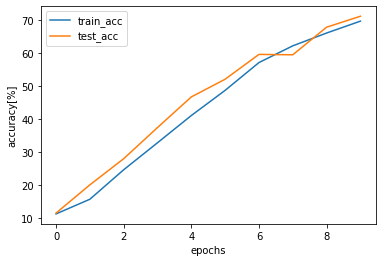

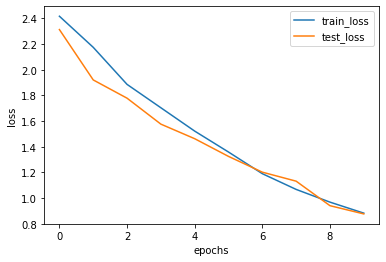

10/15 11:23:18 AM epoch 11
10/15 11:23:18 AM lr 0.01
10/15 11:23:18 AM train 000 7.130508e-01 75.000000 100.000000
10/15 11:23:24 AM train 100 8.269498e-01 71.565594 97.586634


In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_baseline", lr=0.01, epochs=400,
       scheduler=optim.lr_scheduler.ReduceLROnPlateau,
       scheduler_args={'mode':'min', 'factor':0.5, 'patience':10},
       train_size=20000, valid_size=0, test_size=2500, sampler=ForwardSampler(),
       dir='')

Experiment dir : exp_vgg19_baseline-2020-10-15_19-20-54
10/15 10:20:54 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=400, gene='VGG19', graph=<networkx.classes.digraph.DiGraph object at 0x7fefea24ab00>, lr=0.01, lr_alpha=0.0, momentum=0.9, origin_dir='', report=100, sampler=<__main__.ForwardSampler object at 0x7fefea24a278>, save='exp_vgg19_baseline-2020-10-15_19-20-54', save_weight=False, scheduler=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, scheduler_args={'mode': 'min', 'factor': 0.1, 'patience': 10}, seed=41, stride_max=2, test_size=2500, train_size=20000, valid_size=0)
10/15 10:20:54 AM gene [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
10/15 10:20:54 AM model param 20040522
Files already downloaded and verified
Files already downloaded and verified


10/15 10:20:56 AM epoch 1
10/15 10:20:56 AM lr 0.01
10/15 10:20:56 AM train 000 2.620362e+00 17.187500 46.875000
10/15 10:21:01 AM train 100 2.667879e+00 10.519802 51.314975
10/15 10:21:07 AM train 200 2.486892e+00 11.124067 51.850124
10/15 10:21:12 AM train 300 2.421820e+00 11.202243 51.977782
10/15 10:21:13 AM train_acc 11.195000
10/15 10:21:13 AM valid 000 2.355224e+00 15.625000 53.125000
10/15 10:21:14 AM valid_acc 11.440000
10/15 10:21:14 AM epoch 2
10/15 10:21:14 AM lr 0.01
10/15 10:21:15 AM train 000 2.255345e+00 14.062500 35.937500
10/15 10:21:20 AM train 100 2.290896e+00 11.772896 52.707302
10/15 10:21:25 AM train 200 2.262992e+00 12.943097 56.358831
10/15 10:21:31 AM train 300 2.182150e+00 15.547135 63.616071
10/15 10:21:31 AM train_acc 15.640000
10/15 10:21:31 AM valid 000 1.905586e+00 14.062500 84.375000
10/15 10:21:32 AM valid_acc 20.000000
10/15 10:21:33 AM epoch 3
10/15 10:21:33 AM lr 0.01
10/15 10:21:33 AM train 000 1.867513e+00 20.312500 82.812500
10/15 10:21:39 AM tra

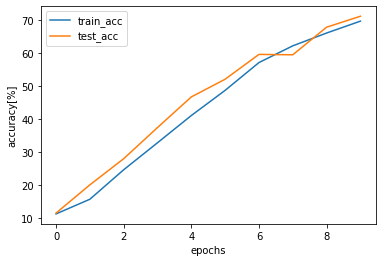

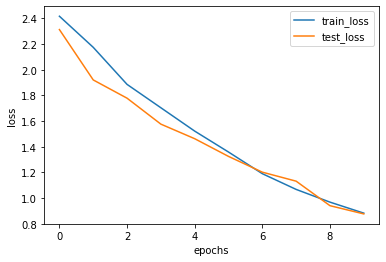

10/15 10:24:08 AM epoch 11
10/15 10:24:08 AM lr 0.01
10/15 10:24:08 AM train 000 7.130508e-01 75.000000 100.000000
10/15 10:24:13 AM train 100 8.269498e-01 71.565594 97.586634
10/15 10:24:19 AM train 200 8.281317e-01 71.556281 97.450249
10/15 10:24:25 AM train 300 8.188864e-01 72.041113 97.466777
10/15 10:24:25 AM train_acc 72.040000
10/15 10:24:25 AM valid 000 6.120632e-01 81.250000 100.000000
10/15 10:24:26 AM valid_acc 72.760000
10/15 10:24:27 AM epoch 12
10/15 10:24:27 AM lr 0.01
10/15 10:24:27 AM train 000 8.221028e-01 68.750000 100.000000
10/15 10:24:33 AM train 100 7.566988e-01 74.489480 97.926980
10/15 10:24:38 AM train 200 7.555991e-01 74.681281 97.683458
10/15 10:24:44 AM train 300 7.507583e-01 74.807932 97.715947
10/15 10:24:45 AM train_acc 74.780000
10/15 10:24:45 AM valid 000 7.672992e-01 75.000000 100.000000
10/15 10:24:46 AM valid_acc 70.080000
10/15 10:24:46 AM epoch 13
10/15 10:24:46 AM lr 0.01
10/15 10:24:46 AM train 000 9.503343e-01 67.187500 100.000000
10/15 10:24:5

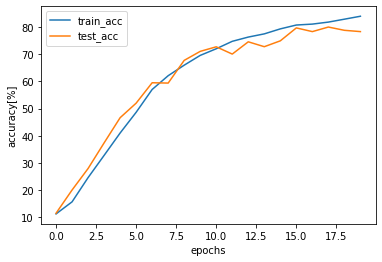

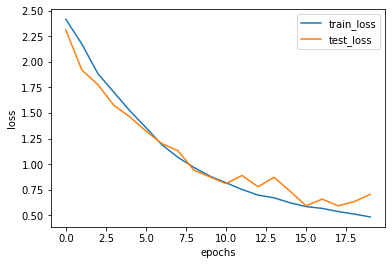

10/15 10:27:27 AM epoch 21
10/15 10:27:27 AM lr 0.01
10/15 10:27:27 AM train 000 3.846731e-01 90.625000 98.437500
10/15 10:27:32 AM train 100 4.688436e-01 84.251238 99.102723
10/15 10:27:38 AM train 200 4.681270e-01 84.359453 99.059391
10/15 10:27:44 AM train 300 4.681084e-01 84.286752 99.003322
10/15 10:27:45 AM train_acc 84.325000
10/15 10:27:45 AM valid 000 2.701558e-01 95.312500 100.000000
10/15 10:27:45 AM valid_acc 79.840000
10/15 10:27:46 AM epoch 22
10/15 10:27:46 AM lr 0.01
10/15 10:27:46 AM train 000 4.730900e-01 82.812500 98.437500
10/15 10:27:52 AM train 100 4.347314e-01 85.581683 99.195545
10/15 10:27:58 AM train 200 4.454241e-01 85.004664 99.183769
10/15 10:28:03 AM train 300 4.448640e-01 85.070598 99.112334
10/15 10:28:04 AM train_acc 85.035000
10/15 10:28:04 AM valid 000 2.851300e-01 89.062500 100.000000
10/15 10:28:05 AM valid_acc 82.000000
10/15 10:28:06 AM epoch 23
10/15 10:28:06 AM lr 0.01
10/15 10:28:06 AM train 000 4.404418e-01 85.937500 98.437500
10/15 10:28:12 A

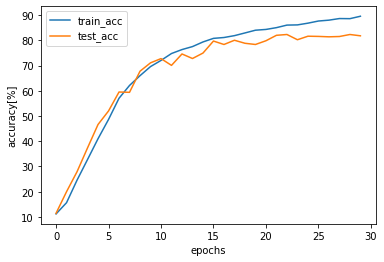

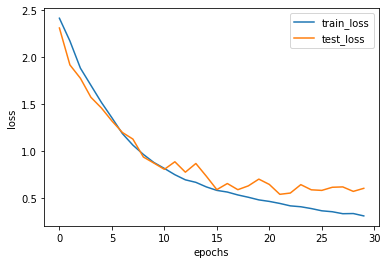

10/15 10:30:46 AM epoch 31
10/15 10:30:46 AM lr 0.01
10/15 10:30:46 AM train 000 2.961771e-01 90.625000 100.000000
10/15 10:30:52 AM train 100 2.910853e-01 90.176361 99.659653
10/15 10:30:57 AM train 200 3.051288e-01 89.800995 99.650187
10/15 10:31:03 AM train 300 3.097200e-01 89.700997 99.595100
10/15 10:31:04 AM train_acc 89.710000
10/15 10:31:04 AM valid 000 3.189742e-01 92.187500 98.437500
10/15 10:31:05 AM valid_acc 82.840000
10/15 10:31:05 AM epoch 32
10/15 10:31:05 AM lr 0.01
10/15 10:31:05 AM train 000 3.537611e-01 90.625000 96.875000
10/15 10:31:11 AM train 100 2.750901e-01 90.594059 99.690594
10/15 10:31:17 AM train 200 2.844648e-01 90.321828 99.619092
10/15 10:31:23 AM train 300 2.862453e-01 90.432932 99.652201
10/15 10:31:23 AM train_acc 90.360000
10/15 10:31:23 AM valid 000 4.381500e-01 89.062500 100.000000
10/15 10:31:24 AM valid_acc 81.720000
10/15 10:31:25 AM epoch 33
10/15 10:31:25 AM lr 0.01
10/15 10:31:25 AM train 000 3.629831e-01 85.937500 100.000000
10/15 10:31:31 

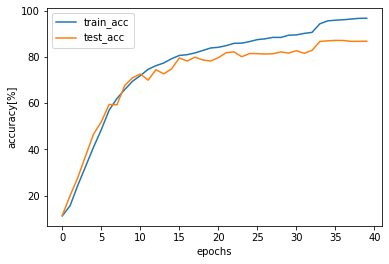

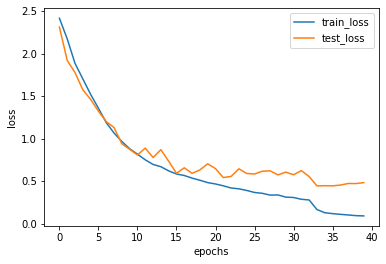

10/15 10:34:05 AM epoch 41
10/15 10:34:05 AM lr 0.001
10/15 10:34:05 AM train 000 1.394523e-01 93.750000 100.000000
10/15 10:34:11 AM train 100 7.812881e-02 97.694926 99.907178
10/15 10:34:16 AM train 200 7.896457e-02 97.644590 99.922264
10/15 10:34:22 AM train 300 8.260468e-02 97.461586 99.922135
10/15 10:34:23 AM train_acc 97.460000
10/15 10:34:23 AM valid 000 2.351502e-01 92.187500 100.000000
10/15 10:34:24 AM valid_acc 87.200000
10/15 10:34:24 AM epoch 42
10/15 10:34:24 AM lr 0.001
10/15 10:34:25 AM train 000 5.168836e-02 98.437500 100.000000
10/15 10:34:30 AM train 100 8.039974e-02 97.416460 99.938119
10/15 10:34:36 AM train 200 7.984418e-02 97.310323 99.961132
10/15 10:34:42 AM train 300 7.963596e-02 97.357766 99.958472
10/15 10:34:42 AM train_acc 97.345000
10/15 10:34:42 AM valid 000 2.839271e-01 92.187500 100.000000
10/15 10:34:43 AM valid_acc 87.480000
10/15 10:34:44 AM epoch 43
10/15 10:34:44 AM lr 0.001
10/15 10:34:44 AM train 000 3.756165e-02 98.437500 100.000000
10/15 10:3

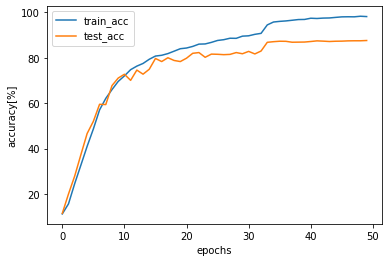

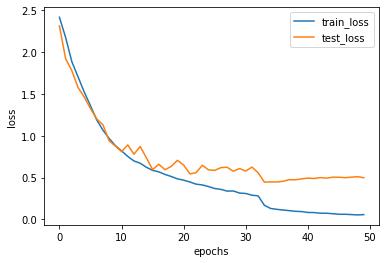

10/15 10:37:25 AM epoch 51
10/15 10:37:25 AM lr 0.0001
10/15 10:37:25 AM train 000 2.630119e-02 100.000000 100.000000
10/15 10:37:30 AM train 100 5.193241e-02 98.205446 99.984530
10/15 10:37:36 AM train 200 5.676755e-02 98.079913 99.984453
10/15 10:37:42 AM train 300 5.540466e-02 98.136420 99.979236
10/15 10:37:42 AM train_acc 98.100000
10/15 10:37:43 AM valid 000 1.922381e-01 93.750000 100.000000
10/15 10:37:43 AM valid_acc 87.520000
10/15 10:37:44 AM epoch 52
10/15 10:37:44 AM lr 0.0001
10/15 10:37:44 AM train 000 9.795285e-03 100.000000 100.000000
10/15 10:37:50 AM train 100 5.388610e-02 98.220916 99.953589
10/15 10:37:56 AM train 200 5.233706e-02 98.274254 99.968905
10/15 10:38:01 AM train 300 5.270955e-02 98.245432 99.979236
10/15 10:38:02 AM train_acc 98.290000
10/15 10:38:02 AM valid 000 2.252683e-01 93.750000 100.000000
10/15 10:38:03 AM valid_acc 87.480000
10/15 10:38:04 AM epoch 53
10/15 10:38:04 AM lr 0.0001
10/15 10:38:04 AM train 000 1.282917e-02 100.000000 100.000000
10/1

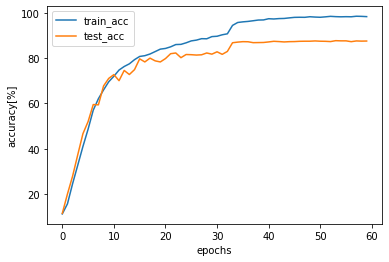

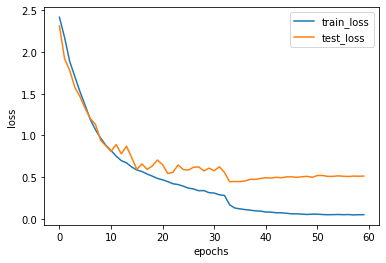

10/15 10:40:45 AM epoch 61
10/15 10:40:45 AM lr 1e-05
10/15 10:40:45 AM train 000 1.822646e-02 100.000000 100.000000
10/15 10:40:50 AM train 100 4.677961e-02 98.406559 99.984530
10/15 10:40:56 AM train 200 5.055228e-02 98.359764 99.992226
10/15 10:41:02 AM train 300 4.972699e-02 98.416736 99.994809
10/15 10:41:02 AM train_acc 98.400000
10/15 10:41:03 AM valid 000 2.043353e-01 93.750000 100.000000
10/15 10:41:03 AM valid_acc 87.600000
10/15 10:41:04 AM epoch 62
10/15 10:41:04 AM lr 1e-05
10/15 10:41:04 AM train 000 7.531203e-02 95.312500 100.000000
10/15 10:41:10 AM train 100 4.769873e-02 98.375619 99.969059
10/15 10:41:16 AM train 200 5.036799e-02 98.258706 99.984453
10/15 10:41:21 AM train 300 5.094046e-02 98.286960 99.984427
10/15 10:41:22 AM train_acc 98.275000
10/15 10:41:22 AM valid 000 2.197034e-01 92.187500 100.000000
10/15 10:41:23 AM valid_acc 87.440000
10/15 10:41:23 AM epoch 63
10/15 10:41:23 AM lr 1e-05
10/15 10:41:24 AM train 000 2.597991e-02 98.437500 100.000000
10/15 10:

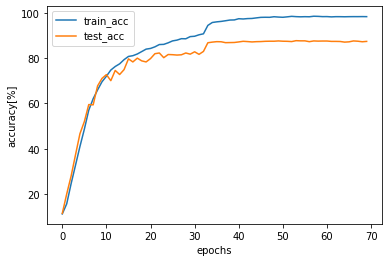

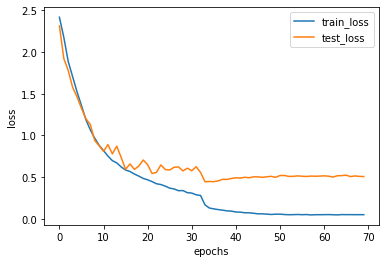

10/15 10:44:05 AM epoch 71
10/15 10:44:05 AM lr 1.0000000000000002e-06
10/15 10:44:05 AM train 000 3.540048e-02 98.437500 100.000000
10/15 10:44:11 AM train 100 5.060892e-02 98.452970 100.000000
10/15 10:44:16 AM train 200 4.915533e-02 98.484142 99.992226
10/15 10:44:22 AM train 300 5.038912e-02 98.401163 99.994809
10/15 10:44:23 AM train_acc 98.390000
10/15 10:44:23 AM valid 000 2.111915e-01 93.750000 100.000000
10/15 10:44:24 AM valid_acc 87.480000
10/15 10:44:24 AM epoch 72
10/15 10:44:24 AM lr 1.0000000000000002e-06
10/15 10:44:25 AM train 000 1.086209e-01 95.312500 100.000000
10/15 10:44:30 AM train 100 4.555178e-02 98.499381 100.000000
10/15 10:44:36 AM train 200 4.733181e-02 98.546331 99.992226
10/15 10:44:42 AM train 300 4.947828e-02 98.468646 99.994809
10/15 10:44:42 AM train_acc 98.470000
10/15 10:44:43 AM valid 000 2.097467e-01 92.187500 100.000000
10/15 10:44:43 AM valid_acc 87.360000
10/15 10:44:44 AM epoch 73
10/15 10:44:44 AM lr 1.0000000000000002e-06
10/15 10:44:44 AM t

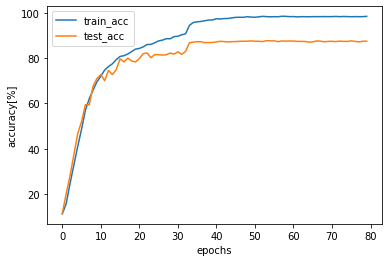

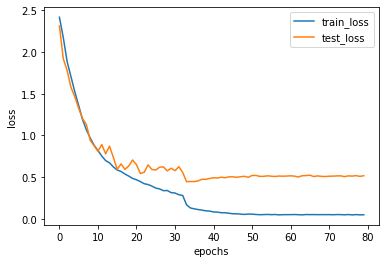

10/15 10:47:27 AM epoch 81
10/15 10:47:27 AM lr 1.0000000000000002e-07
10/15 10:47:27 AM train 000 1.648871e-02 100.000000 100.000000
10/15 10:47:33 AM train 100 5.421916e-02 98.282797 99.969059
10/15 10:47:38 AM train 200 5.059882e-02 98.336443 99.976679
10/15 10:47:44 AM train 300 5.173121e-02 98.318106 99.979236
10/15 10:47:45 AM train_acc 98.320000
10/15 10:47:45 AM valid 000 2.031036e-01 93.750000 100.000000
10/15 10:47:46 AM valid_acc 87.400000
10/15 10:47:47 AM epoch 82
10/15 10:47:47 AM lr 1.0000000000000002e-07
10/15 10:47:47 AM train 000 5.252003e-03 100.000000 100.000000
10/15 10:47:52 AM train 100 5.031048e-02 98.344678 99.984530
10/15 10:47:58 AM train 200 5.075030e-02 98.344216 99.984453
10/15 10:48:04 AM train 300 4.954402e-02 98.375208 99.989618
10/15 10:48:04 AM train_acc 98.390000
10/15 10:48:05 AM valid 000 2.016947e-01 93.750000 100.000000
10/15 10:48:05 AM valid_acc 87.440000
10/15 10:48:06 AM epoch 83
10/15 10:48:06 AM lr 1.0000000000000002e-07
10/15 10:48:06 AM t

KeyboardInterrupt: ignored

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_baseline", lr=0.01, epochs=400,
       scheduler=optim.lr_scheduler.ReduceLROnPlateau,
       scheduler_args={'mode':'min', 'factor':0.1, 'patience':10},
       train_size=20000, valid_size=0, test_size=2500, sampler=ForwardSampler(),
       dir='')

- time watch